# Nested Sampling with `dynesty`: Error Analysis

This is a simple interactive demo that outlines nested sampling error analysis in `dynesty`. This is meant to be a living document that will eventually get turned into documentation at some point in the future.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Target Distribution

For this demonstration, we will return to the **correlated multivariate normal** case used earlier with a uniform prior from $[-10, 10]$.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

# Quick Review

**Bayes' Rule** states that given some **data** $\mathbf{D}$ and **model** $M$ with **parameters** $\boldsymbol{\Theta}$ we can write the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ as

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)} $$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

**Nested sampling** [(Skilling 2006)](https://projecteuclid.org/euclid.ba/1340370944) is designed to estimate $\mathcal{Z}$ by transforming this N-D integral over all $\boldsymbol{\Theta}$ to a 1-D integral over the **prior volume** 

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

contained within an **iso-likelihood contour** set by $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$ such that

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. Computing the evidence using these "nested shells" is what gives nested sampling its name.

# Deriving Approximate Evidence Errors

In a given nested sampling run with $K$ live points, the prior volume evolves as

$$ \Delta \ln X_i \approx 1 /K \quad .$$

The **"information"** gained from moving from the prior $\pi(\boldsymbol{\Theta})$ to the posterior $p(\boldsymbol{\Theta})$ can be quantified using the **KL Divergence** between the two distributions,

$$ H \equiv \int_{\Omega_{\boldsymbol{\Theta}}} p(\boldsymbol{\Theta}) \ln\left(\frac{p(\boldsymbol{\Theta})}{\pi(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} \quad . $$

The number of steps needed for the distribution to start from the prior and integrate over the entire posterior is then roughly $\approx HK$, since we compress by $\approx 1/K$ each time and need to "cover" $H$. Assuming the number of steps follows a Poisson distribution, this gives a standard deviation of $\sigma_{\ln \mathcal{Z}} \approx \sqrt{H/K}$.

To incorporate variable numbers of live points, we can re-write this expression in terms of the variance as 

$$ \mathbb{V}(\ln \mathcal{Z}) \approx \sum_{i=1}^{n} \Delta H_i \Delta \ln X_i \quad .$$ 

Under the case that where $K_i = K$, our change in volume reduces to $\Delta \ln X_i \approx 1/K$ and we get $\mathbb{V}(\ln \mathcal{Z}) \approx \sum_{i=1}^{n} \Delta H_i / K \approx H/K$, as expected. This is the method used to compute the "default" error estimates provided in `dynesty`. 

**We cannot stress enough that this result relies on crude, first-order approximations to our change in volume. This can lead to significant under/over-estimates (including negative values), especially if $\Delta \ln K_i$ is large with large(r) uncertainties. (So please don't panic if the error bars become ill-defined during a run!)**

Although we've shown the results of these approximate calculations before, we'll just show them again using `NestedSampler` and `DynamicNestedSampler`.

In [5]:
# "standard" nested sampling
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                bound='single', nlive=1000)
sampler.run_nested(dlogz=0.01)
res = sampler.results

# dynamic nested sampling
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, 
                                        bound='single', sample='unif')
dsampler.run_nested(nlive_init=100, nlive_batch=100, maxiter=res.niter+res.nlive, use_stop=False)
dres = dsampler.results

iter: 13361+1000 | nc: 1 | ncall: 20325 | eff(%): 70.657 | logz: -9.038 +/-  0.085 | dlogz:  0.000 <  0.010    
iter: 14361 | batch: 30 | nc: 1 | ncall: 28132 | eff(%): 51.049 | loglstar:   -inf < -1.118 < -1.077 | logz: -9.211 +/-  0.149 | stop:    nan       


In [6]:
from dynesty import plotting as dyplot

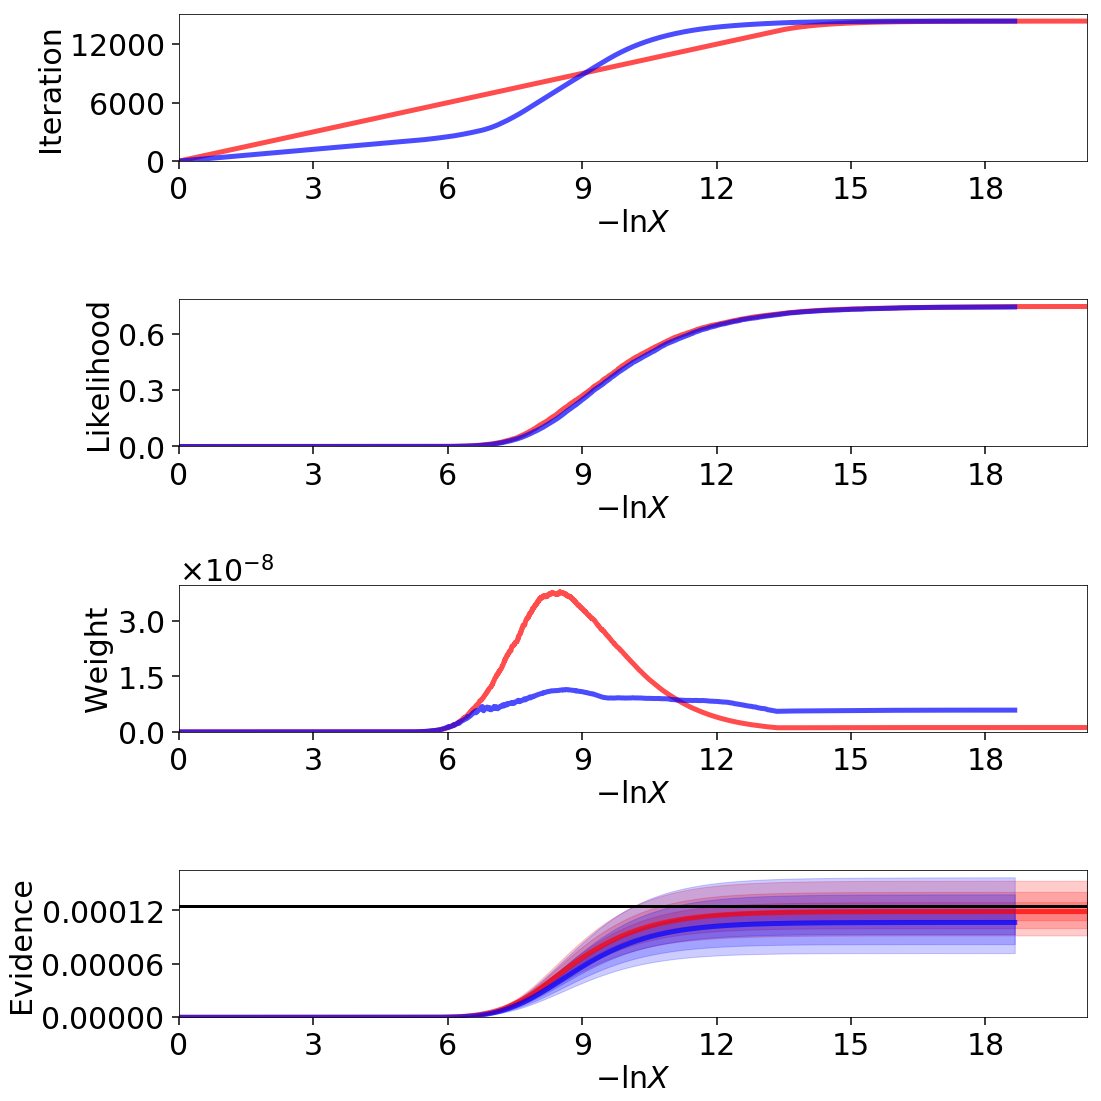

In [7]:
lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution

# plotting results
fig, axes = dyplot.runplot(res, color='red', mark_final_live=False)
fig, axes = dyplot.runplot(dres, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, truth_color='black')
fig.tight_layout()

# Deriving Exact Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful (in some cases *exact*) uncertainty estimates on our resulting evidence (and posteriors) **using a single run**. We'll go into some of the details below.

# Deriving Statistical Uncertainties

## Order Statistics

Nested sampling works thanks to the magic of **order statistics**. At the start of our run, we sample $K$ points from the prior with likelihoods $\lbrace \mathcal{L}_1,\dots,\mathcal{L}_{K} \rbrace$ and associated prior volumes $ \lbrace X_1,\dots,X_K \rbrace$. We then want to pick the point with the *smallest* (worst) likelihood $\mathcal{L}_{(1)}$ out of the ordered set $\lbrace \mathcal{L}_{(1)},\dots,\mathcal{L}_{(K)} \rbrace$ from smallest to largest. These likelihoods correspond to an ordered set of prior volumes $\lbrace X_{(1)},\dots,X_{(K)} \rbrace$, where the likelihoods and prior volumes are inversely ordered such that $\mathcal{L}_{(i)} \leftrightarrow X_{(K-i+1)}$.

What is this prior volume? Well, all the points were drawn from the prior, so by the **probability integral transform (PIT)** the corresponding prior volumes are uniformly distributed **random variables** such that

$$ X_1,\dots,X_K \stackrel{i.i.d.}{\sim} \textrm{Unif} $$

where $\textrm{Unif}$ is the standard uniform distribution. It can be shown that the set of *ordered* uniform random variables (here our prior volumes) can be *jointly* represented by $K+1$ exponential random variables

$$ X_{(j)} \sim \frac{Y_1 + \cdots + Y_j}{Y_1 + \cdots + Y_{K+1}} \quad , \quad Y_1,\dots,Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} $$

where $\textrm{Expo}$ is the standard Exponential distribution.

## Case 1: Constant Number of Live Points

We are interested in the marginal distribution of $X_{(K)}$ associated with $\mathcal{L}_{(1)}$, since that's the prior volume of the live point with the worst likelihood. This turns out to be

$$ X_{(j=K)} \sim \textrm{Beta}(j,K-j+1) = \textrm{Beta}(K,1) $$

where $\textrm{Beta}(\alpha,\beta)$ is the Beta distribution.

Once we replace a live point with a new live point that satisfies this constraint, we now want to do the same procedure again. Using the same logic as above, we know that our prior volumes must be i.i.d. uniformly distributed *within the previous volume* (since we just replace the worst point with a new independent draw). At a given iteration $i$ where we just replaced point $i-1$ with prior volume $X_{i-1}$, the prior volume associated with a new $X_i$ we're now trying to remove is then

$$ X_i = t_i X_{i-1} ~,~ t_i \sim \textrm{Beta}(K,1) \quad \Rightarrow \quad X_i = \prod_{j=1}^{i} t_j ~,~ t_1,\dots,t_i \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad . $$

This has an expectation value of

$$ \mathbb{E}(X_i) = \prod_{j=1}^{i} \mathbb{E}(t_j) = \left(\frac{K}{K+1}\right)^i \rightarrow \ln \left[ \mathbb{E}(X_i) \right] = i \, [\ln K - \ln(K+1)] \quad . $$

In other words, we *exponentially* compress our prior volume at each iteration, shrinking by (on average) a factor of $K/(K+1)$.

## Case 2: Decreasing Number of Live Points

Once the algorithm terminantes after $N$ iterations using some stopping criteria, we are then left with a set of $K$ live points and a final set of $\lbrace X_{N+1}=X_{(1)}, \dots, X_{N+K}=X_{(K)} \rbrace$ prior volumes. Going back to our earlier results from order statistics, we can jointly represent the ratio of their volumes with respect to $X_N$ as

$$ \frac{X_{N+j}}{X_N} \sim \frac{Y_1 + \cdots + Y_{K-j+1}}{Y_1 + \dots + Y_{K+1}} \quad . $$

These have expectation values of

$$ \mathbb{E}\left(\frac{X_{N+j}}{X_N}\right) = \frac{K - j + 1}{K+1} $$

In other words, we *uniformly* compress our prior volume over the final set of live points, shrinking the prior volume in constant increments of $1/(K+1)$ each time.

## Extension to Dynamic Nested Sampling

In a dynamic sampling run, the number of live points $K_i$ can change at each iteration $i$. How does this impact the sampling behavior using our results from above?
1. In the case where the number of live points increases or remains constant such that $K_i \geq K_{i-1}$, we can use the same logic as Case 1 to show that the prior volume is distributed as $X_i = t_i X_{i-1}$ where $t_i \sim \textrm{Beta}(K_i, 1)$ and therefore decreases *exponentially* by a factor of $K_i/(K_i+1)$. 
2. In the case where it decreases such that $K_i < K_{i-1}$, we can use the same logic as Case 2 to show that our prior volume instead decreases *uniformly* by a constant increment $1/(K_{i-1}+1)$ (and shares the same joint distribution structure).

These two cases imply that as we change the number of live points our sampler effectively alternates between exponentially and uniformly compressing our prior volume.

## Implementation in `dynesty`

`dynesty` contains a variety of useful utilities in the `utils` package, including a convenience function for extracting a number of samples from a run with equal weights (`resample_equal`), a convenience function for computing means and covariances (`mean_and_cov`), and a substitute for `np.random.choice` (`random_choice`).

In [8]:
dynesty.utils.__all__

['resample_equal',
 'mean_and_cov',
 'random_choice',
 'jitter_run',
 'resample_run',
 'simulate_run',
 'unravel_run',
 'merge_runs',
 'kl_divergence',
 'kld_error']

More importantly, however, it contains several functions that operate over the output `Results` dictionary from a nested sampling run in `dynesty` which implement the theoretical results discussed in this notebook.

**`jitter_run`** simulates the intrinsic, **statistical** uncertainties in nested sampling. These arise from uncertainties on the prior volume and are unique to nested sampling. Given the results discussed above, `jitter_run` draws a large number of random variables from the corresponding (joint) distributions to simulate the possible prior volumes associated with each dead point from a particular run. It then returns a new `Results` dictionary with a new set of prior volumes, importance weights, and evidences (with errors). This approach of adding "jitter" to the weights works for both standard and dynamic runs and can capture complex covariances, as shown below.

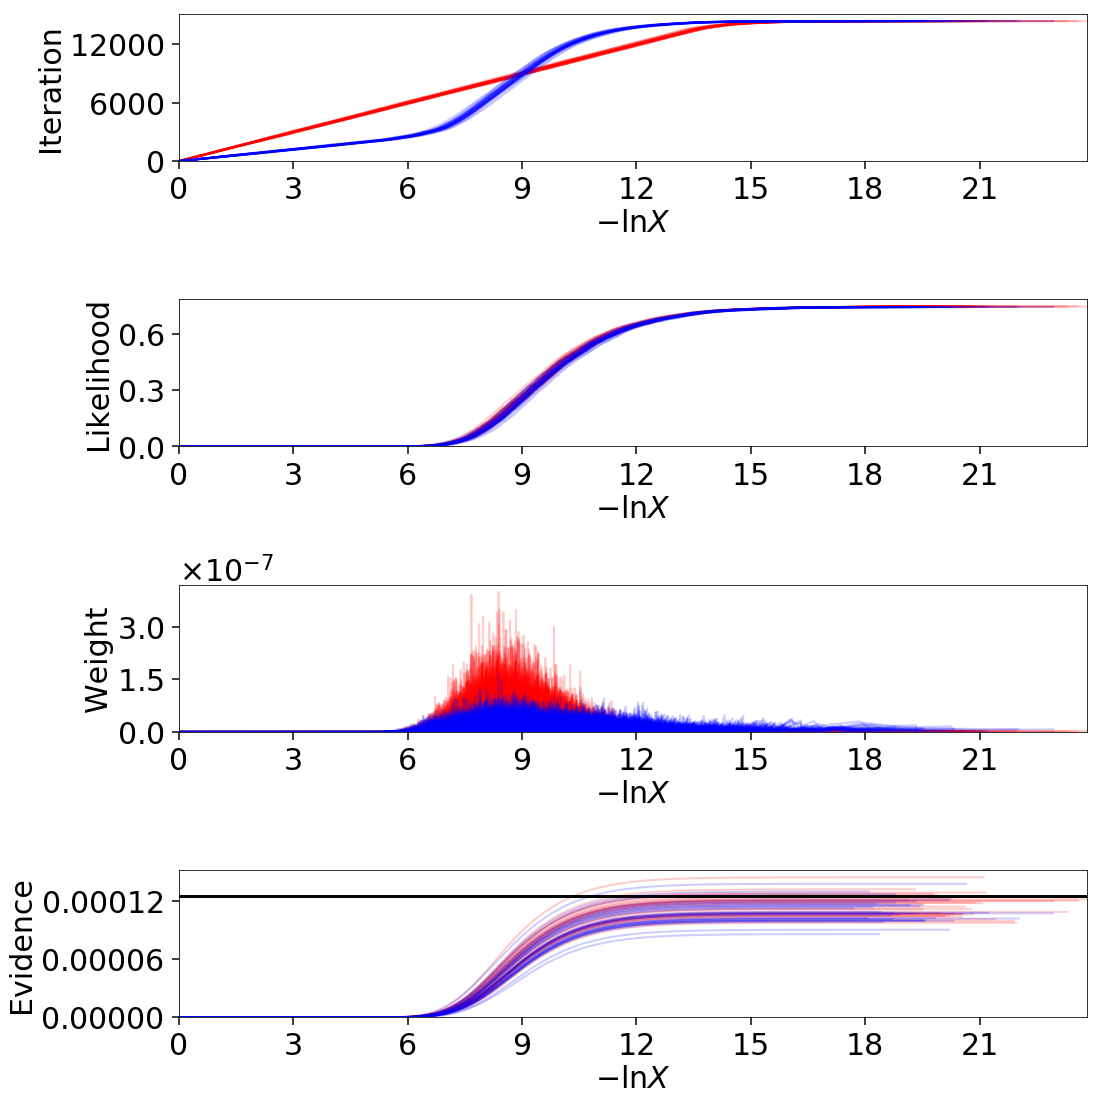

In [9]:
# plotting results
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(30):
    sim_res = dynesty.utils.jitter_run(res)
    fig, axes = dyplot.runplot(sim_res, color='red', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(30):
    sim_dres = dynesty.utils.jitter_run(dres)
    fig, axes = dyplot.runplot(sim_dres, color='blue', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black', truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

## Comparison to True Values

For particular distributions such as multivariate normals, the prior volume 

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

can be computed directly as a function of lambda because the distribution is symmetric. In particular, in the our case where we have a multivariate normal with given covariance $\mathbf{C}$ (and assumed mean $\boldsymbol{\mu}=\mathbf{0}$), there is a given ellipsoid whose axes can be parameterized by a matrix $A = r(\lambda) \mathbf{C}$ whose surface forms the iso-likelihood contour at $\lambda$. The specific value of $r(\lambda)$ can be computed directly from a sample $\lambda = \mathcal{L}(\boldsymbol{\Theta}_i)$ via $r^2 = \boldsymbol{\Theta}_i^T \mathbf{C}^{-1} \boldsymbol{\Theta}_i$. The "prior volume" is then just the portion of the prior contained within this ellipsoid, which for our case of a uniform prior is just the volume of the ellipsoid contained within the unit cube.

We can compute this directly using `dynesty`'s built-in bounding objects (see Demo 3). Let's see how well the first-order approximation used in our dynamic nested sampling run compares to the true prior volumes.

In [10]:
# initialize ellipsoid (in unit cube)
ell = dynesty.bounding.Ellipsoid(ctr=np.zeros(ndim)+0.5, am=np.copy(Cinv))

# compute prior volumes
v_arr = []
exceed = True
for i, u in enumerate(dres.samples_u):
    d = ell.distance(u)  # normalized distance from ellipsoid center
    ell.scale_to_vol(d**ndim * ell.vol)  # scale ellipsoid
    if exceed:
        # compute overlap with unit cube using Monte Carlo methods
        f = ell.unitcube_overlap()
    else:
        # assume the ellipsoid is entirely contained within the unit cube
        f = 1.
    if f > 0.995:
        # stop checking if the last check gave >99% overlap
        exceed = False
    v = ell.vol * f  # compute prior volume
    v_arr.append(v)
    # print progress
    sys.stdout.write('\r{0}/{1}: {2} overlap with {3} volume        '.format(i, dres.niter, f, v))
v_arr = np.array(v_arr)

14360/14361: 1.0 overlap with 3.59564769993e-08 volume        

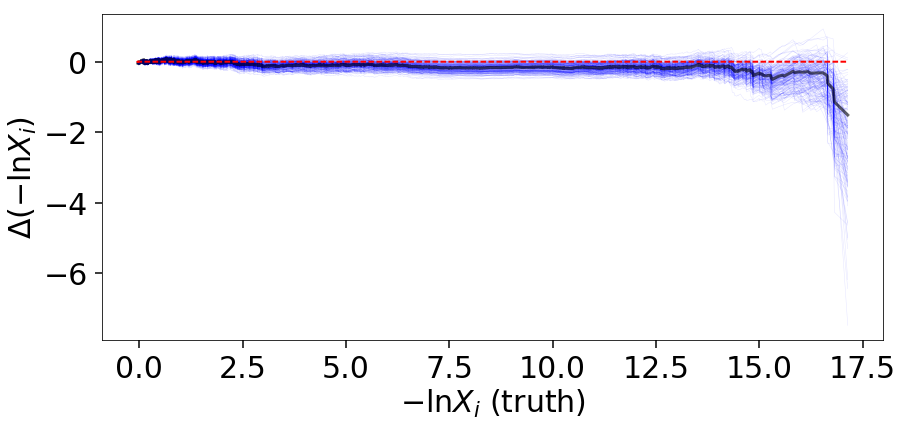

In [11]:
plt.figure(figsize=(14, 6))
[plt.plot(-np.log(v_arr), -np.log(v_arr) + dynesty.utils.jitter_run(dres).logvol, 
          lw=0.5, alpha=0.1, color='blue') for i in range(200)]
plt.plot(-np.log(v_arr), -np.log(v_arr) + dres.logvol, lw=3, alpha=0.6, color='black')
plt.plot(-np.log(v_arr), np.zeros(len(v_arr)), 'r--', lw=2)
plt.xlabel(r'$-\ln X_i$ (truth)')
plt.ylabel(r'$\Delta (-\ln X_i)$');

# Deriving Sampling Uncertainties

In addition to the statistical uncertainties associated with the unknown prior volumes, nested sampling is also subject to sampling uncertainties due to the **"path"** taken by a particular live point through the prior. This encompasses two different sources of error intrinsic to sampling itself. The first is **Monte Carlo noise** that arises from probing a continuous distribution using a finite set of samples. The second is **path-dependency**, where our samples can be correlated in some way rather than fully independent draws from the target distribution.

In other words, although the prior volume $X_i$ at a given iteration $i$ might be known exactly, the particular *position* $\boldsymbol{\Theta}_i$ on the iso-likelihood contour is randomly distributed. This adds some additional noise to our posterior estimates. This can also add noise to our evidence if there are problems with our particular proposal distribution that violate our assumptions above (e.g., our expected prior volume shrinkage is not the actual shrinkage).

## The "Trivially Parallelizable" Nature of Nested Sampling

One way to interpret nested sampling is that it is a scheme that takes a set of ordered likelihoods $0 < \mathcal{L}_1 < \dots < \mathcal{L}_N $ and associates them with a set of corresponding prior volumes $1 > X_1 > \dots > X_N > 0$ using a set number of live points $K$.

One neat property of nested sampling is that if we have two standard nested sampling runs with $K_1$ and $K_2$ live points, respectively, composed of two sets of ordered likelihoods

$$ 0 < \mathcal{L}_{(1)}^{(K_1)} < \dots < \mathcal{L}_{(N)}^{(K_1)}, \quad 0 < \mathcal{L}_{(1)}^{(K_2)} < \dots < \mathcal{L}_{(N)}^{(K_2)} \quad , $$

the combined set of ordered likelihoods has the same properties as the set of ordered likelihoods associated with a run using $K_1+K_2$ live points such that

$$ \left\lbrace 0 < \dots < \mathcal{L}_{(i)}^{(K_1)} < \dots < \mathcal{L}_{(j)}^{(K_2)} < \dots \right\rbrace ~\sim~ \left\lbrace 0 < \mathcal{L}_{(1)}^{(K_1+K_2)} < \dots < \mathcal{L}_{(N)}^{(K_1+K_2)} \right\rbrace \quad .$$

This property can be directly extended to cover combine any $M$ number of nested sampling runs.

This procedure can also be done in reverse, where a nested sampling run with $K$ live points can be "unraveled" into **"strands"**, $K$ runs with 1 live point, which can then be subsequently merged to form a run with any desired combination of live points. This process of **unraveling and merging** a nested sampling run can be done using the **`unravel_run`** and **`merge_runs`** function.

In [12]:
res_list = dynesty.utils.unravel_run(res)  # unravel run
res2 = dynesty.utils.merge_runs(res_list)  # merge strands

Merge: 1000/1000      

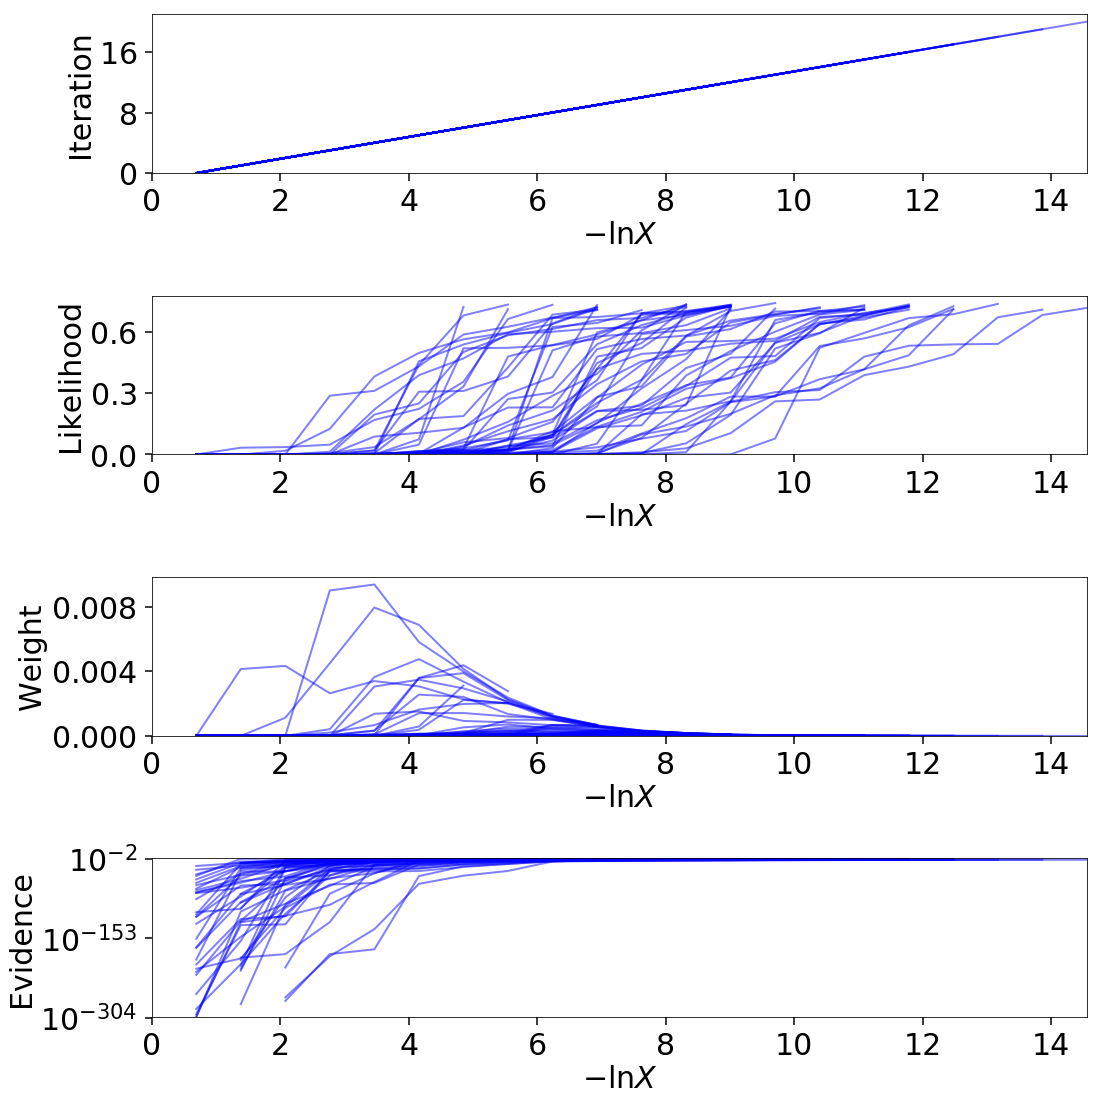

In [13]:
# plotting several strands
fig, axes = dyplot.runplot(res_list[0], plot_kwargs={'linewidth': 2, 'alpha': 0.5},
                           mark_final_live=False, logplot=True, lnz_error=False)
for r in res_list[1:50]:
    fig, axes = dyplot.runplot(r, plot_kwargs={'linewidth': 2, 'alpha': 0.5}, 
                               mark_final_live=False, lnz_error=False,
                               logplot=True, fig=(fig, axes))
fig.tight_layout()

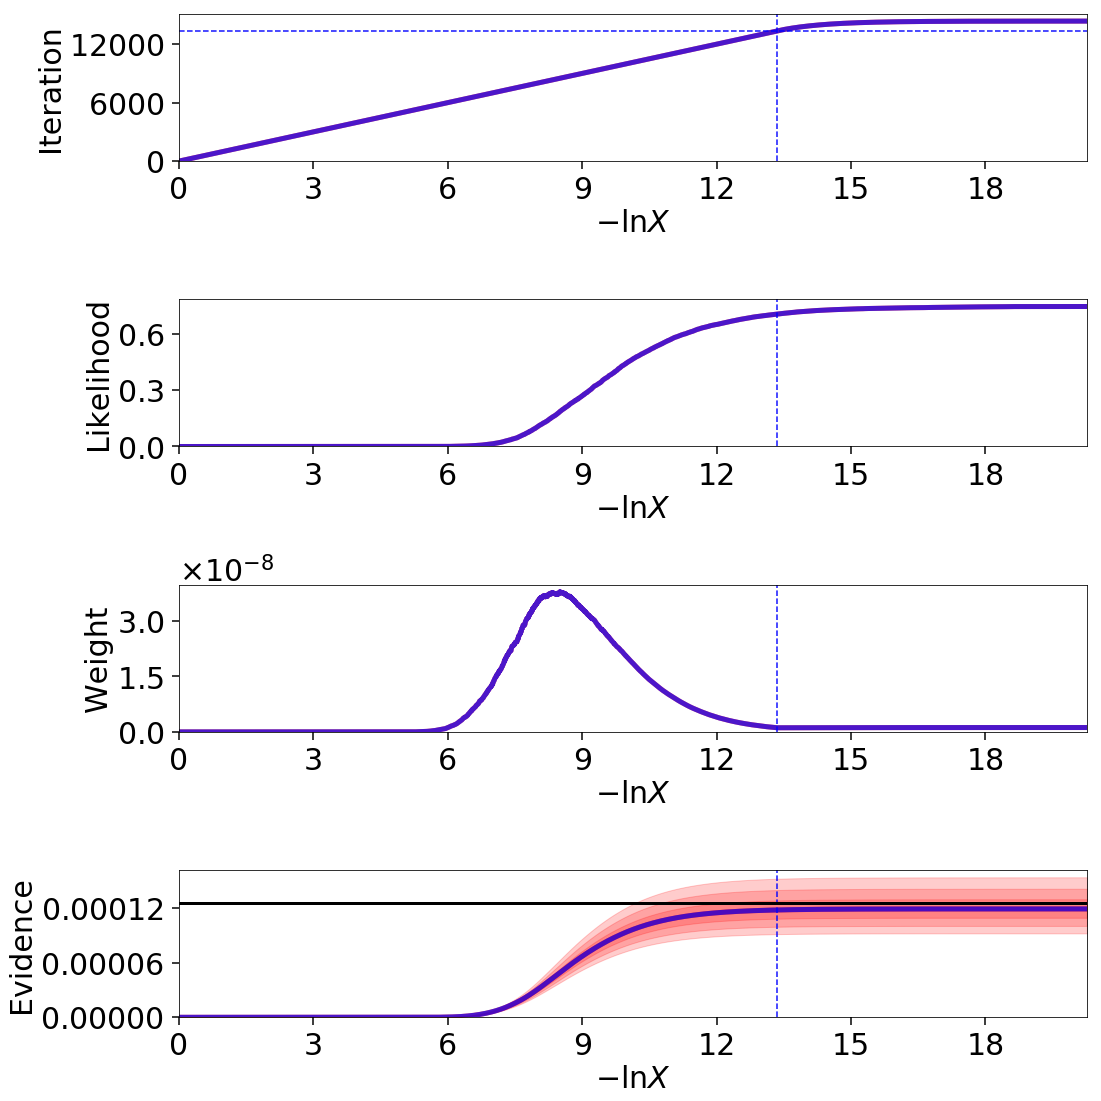

In [14]:
# plotting merged results
fig, axes = dyplot.runplot(res, color='red', mark_final_live=False)
fig, axes = dyplot.runplot(res2, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, lnz_error=False, truth_color='black')
fig.tight_layout()

### Extension to Dynamic Sampling

This "trivially parallelizable" property of nested sampling can also be directly extended to runs over different likelihood ranges. For instance, combining two runs with $K_1$ and $K_2$ live points from $\mathcal{L}_\min^{(K_1)} < \mathcal{L}_\min^{(K_2)} < \mathcal{L}_\max^{(K_2)} < \mathcal{L}_\max^{(K_1)}$ is equivalent to a dynamic nested sampling run with $K_1+K_2$ live points between $\mathcal{L}_\min^{(K_2)} < \mathcal{L}_\max^{(K_2)}$ and $K_1$ elsewhere. This is the procedure used to build up dynamic sampling runs within the `DynamicNestedSampler`.

Both `unravel_run` and `merge_runs` also work with dynamic nested sampling runs, although some of the provided anciliary quantities are not always valid (see the documentation for more details).

In [15]:
dres_list = dynesty.utils.unravel_run(dres)  # unravel run
dres2 = dynesty.utils.merge_runs(dres_list)  # merge strands

Merge: 3101/3100      

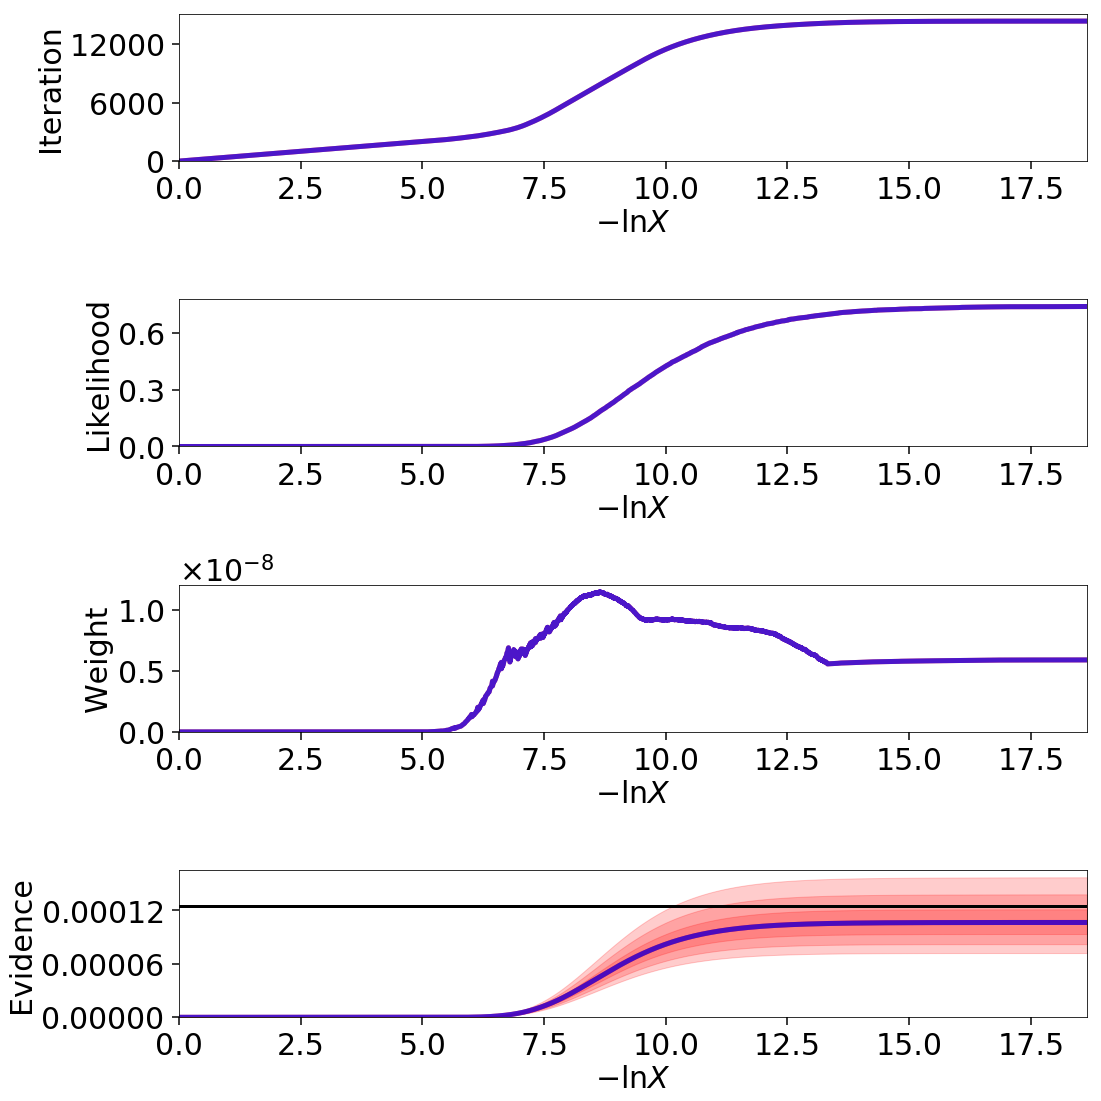

In [16]:
# plotting merged results
fig, axes = dyplot.runplot(dres, color='red', mark_final_live=False)
fig, axes = dyplot.runplot(dres2, color='blue', fig=(fig, axes),
                           lnz_truth=lnz_truth, lnz_error=False, truth_color='black')
fig.tight_layout()

## Bootstrapping Sampling Uncertainties

We can use the "trivially parallelizable" nature of nested sampling to our advantage to probe sampling errors using a bootstrap-like approach. In particular, the particular path a particular live point $i$ takes through the distribution is fully independent of the paths of all the other live points. Running $K$ strands (runs with one live point) and combining them into a single run is then entirely equivalent to a single nested sampling run with $K$ live points.

Under this framework, we can imagine constructing a new run by resampling a new set of $K$ strands from the strands formed by our current set of $K$ live points (which trace out a particular set of paths through the distribution).

### Extension to Dynamic Sampling

When the number of live points remains constant, there is a symmetry in the information content provided by each strand: since all points are initialized from the prior, they provide information on the prior volume at a given iteration, allowing for evidence estimation and posterior inference. Adding live points dynamically, however, breaks this symmetry since not all strands are initialized from the prior. Computing the prior volumes (and importance weights) for these "add-on" strands requires a set of "baseline" strands initialized from the prior to anchor their positions. This means that when bootstrapping, we just need to resample strands from each group separately.

Similar to `jitter_run`, users can construct these **resampled runs** using the **`resample_run`** function.

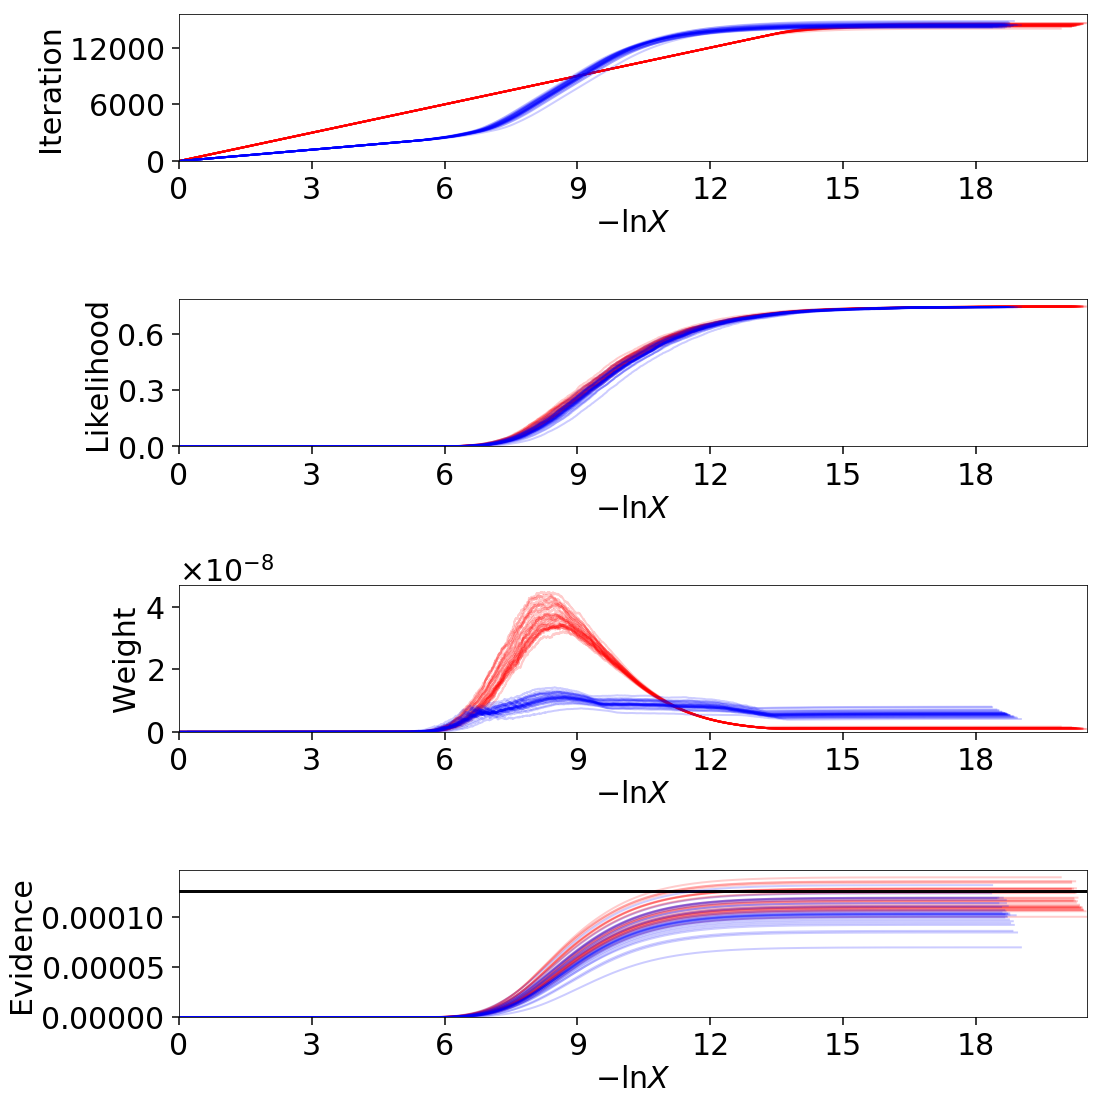

In [17]:
# plotting results
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(30):
    rsamp_res = dynesty.utils.resample_run(res)
    fig, axes = dyplot.runplot(rsamp_res, color='red', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(30):
    rsamp_dres = dynesty.utils.resample_run(dres)
    fig, axes = dyplot.runplot(rsamp_dres, color='blue', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black', truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

# Combining Uncertainties

Above, we've outlined how both statistical and sampling uncertainties contribute to nested sampling errors. To recap, the statistical uncertainties are those associated with the unknown prior volumes for a given run while the sampling uncertainties are from Monte Carlo noise associated with our discrete set of samples. `jitter_run` simulates a set of possible prior volumes associated with a single given run, probing the statistical uncertainties. `resample_run` bootstraps a new nested sampling run (with the expected prior volumes), probing the statistical uncertainties.

The total error budget in nested sampling is the (theoretical) variation present in repeated nested sampling runs combined with all possible prior volume realizations. This can be probed using **`simulate_run`** function, which just internally resamples the run (via `resample_run`) and then simulates the prior volumes (via `jitter_run`).

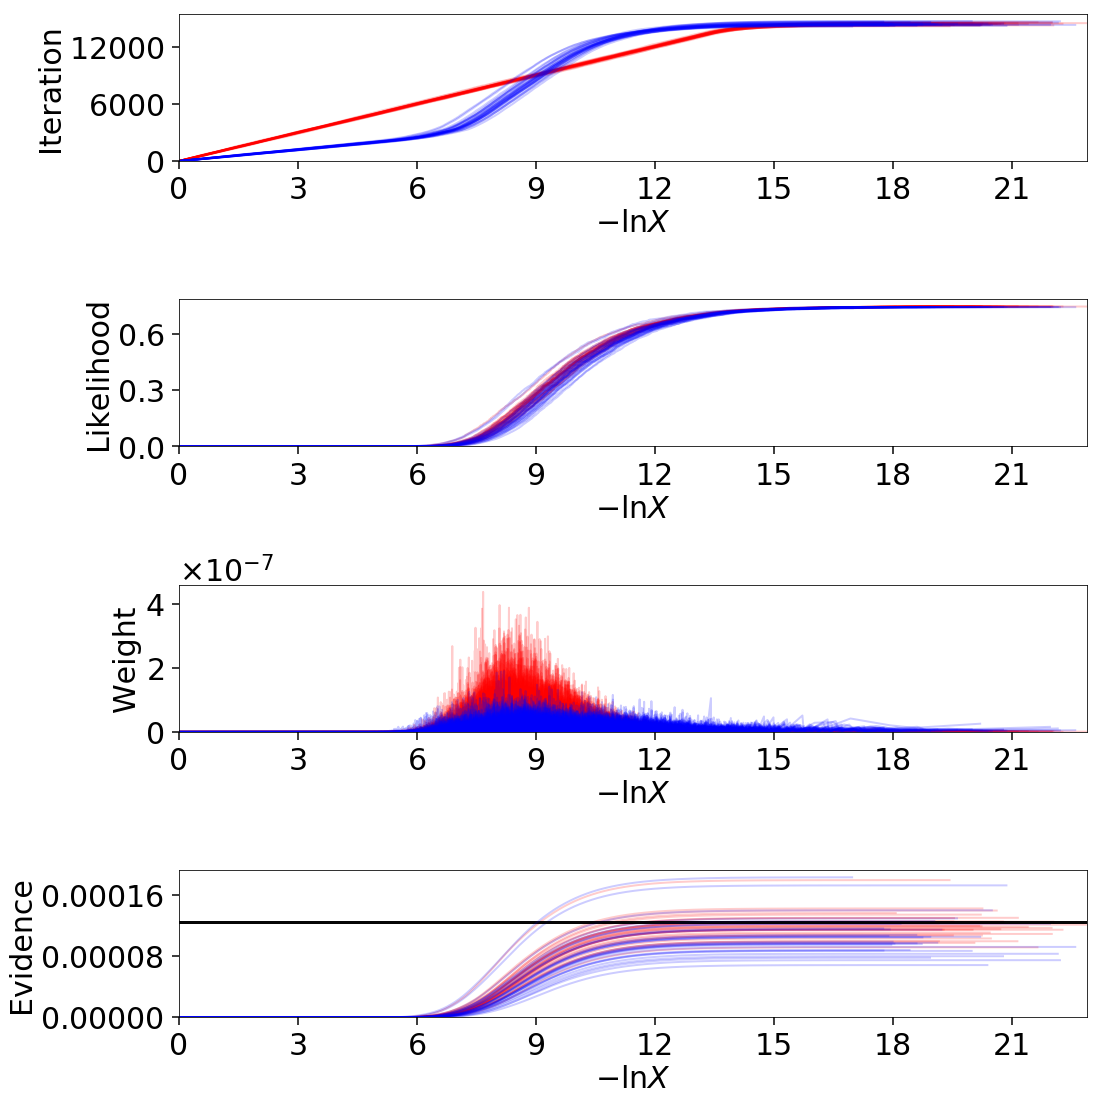

In [18]:
# plotting results
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
for i in range(30):
    rsamp_res = dynesty.utils.simulate_run(res)
    fig, axes = dyplot.runplot(rsamp_res, color='red', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               fig=(fig, axes))
for i in range(30):
    rsamp_dres = dynesty.utils.simulate_run(dres)
    fig, axes = dyplot.runplot(rsamp_dres, color='blue', plot_kwargs={'alpha': 0.2, 'linewidth': 2},
                               mark_final_live=False, lnz_error=False,
                               lnz_truth=lnz_truth, truth_color='black', truth_kwargs={'alpha': 0.1},
                               fig=(fig, axes))
fig.tight_layout()

## Comparison Against Repeated Runs

As a final test to confirm our combined resampling/jittering approach produces robust results, we can compare our results computed using `jitter_run`, `resample_run`, and `simulate_run` directly to results computed from a large number of "repeated" nested sampling runs .

In [19]:
# generate repeat nested sampling runs
Nrepeat = 100
repeat_res = []
sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, bound='single')
for i in range(Nrepeat):
    sampler.reset()
    sampler.run_nested(print_progress=False, maxiter=5000, use_stop=False)
    sys.stderr.write('{0} '.format(i))
    repeat_res.append(sampler.results)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [20]:
# establish our comparison run
sampler.reset()
sampler.run_nested(print_progress=False, maxiter=5000, use_stop=False)
r = sampler.results

Nmc = 500

# jittered runs
sim_res = []
for i in range(Nmc):
    sim_res.append(dynesty.utils.jitter_run(r))

# resampled runs
rsamp_res = []
for i in range(Nmc):
    rsamp_res.append(dynesty.utils.resample_run(r))
    
# simulated runs
samp_res = []
for i in range(Nmc):
    samp_res.append(dynesty.utils.simulate_run(r))

As an initial test, let's compare the estimated $\ln \hat{\mathcal{Z}}$ from each set of runs. We expect that each pair of errors should be broadly similar. By construction, our initial analytic approximation should be similar to the errors from our jittered weights derived from our repeated runs, since both probe sampling uncertainties while ignoring prior volume uncertainties. And the combined "simulated" errors should be similar to our repeated runs using jittered weights since both probe statistical and sampling uncertainties simultaneously.

In [21]:
# compare evidence estimates

# analytic first-order approximation
print('Approx.:     {:6.3f} +/- {:6.3f}'.format(r.logz[-1], r.logzerr[-1]))

# jittered draws
lnz_arr = [results.logz[-1] for results in sim_res]
print('Sim.:        {:6.3f} +/- {:6.3f}'.format(np.mean(lnz_arr), np.std(lnz_arr)))

# resampled draws
lnz_arr = [results.logz[-1] for results in rsamp_res]
print('Resamp.:     {:6.3f} +/- {:6.3f}'.format(np.mean(lnz_arr), np.std(lnz_arr)))

# repeated runs
lnz_arr = [results.logz[-1] for results in repeat_res]
print('Rep. (mean): {:6.3f} +/- {:6.3f}'.format(np.mean(lnz_arr), np.std(lnz_arr)))

# simulated draws
lnz_arr = [results.logz[-1] for results in samp_res]
print('Comb.:       {:6.3f} +/- {:6.3f}'.format(np.mean(lnz_arr), np.std(lnz_arr)))

# jittered draws from repeated runs
lnz_arr = [dynesty.utils.jitter_run(results).logz[-1] for results in repeat_res]
print('Rep. (sim.): {:6.3f} +/- {:6.3f}'.format(np.mean(lnz_arr), np.std(lnz_arr)))

Approx.:     -8.809 +/-  0.252
Sim.:        -8.846 +/-  0.241
Resamp.:     -8.803 +/-  0.256
Rep. (mean): -8.957 +/-  0.235
Comb.:       -8.847 +/-  0.351
Rep. (sim.): -8.963 +/-  0.332


While there are some slight differences, overall we see that each method behaves as expected. As further confirmation, we can also look at the first moments of the posterior.

In [22]:
# compare posterior first moments (single dimension)

# jittered draws
x_arr = np.array([np.average(results.samples[:,0], weights=np.exp(results.logwt)) for results in sim_res])
print('Sim.:      {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# resampled draws
x_arr = np.array([np.average(results.samples[:,0], weights=np.exp(results.logwt)) for results in rsamp_res])
print('Resamp.:   {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# repeated runs
x_arr = np.array([np.average(results.samples[:,0], weights=np.exp(results.logwt)) for results in repeat_res])
print('Repeat:    {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# simulated draws
x_arr = np.array([np.average(results.samples[:,0], weights=np.exp(results.logwt)) for results in samp_res])
print('Comb.:     {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# jittered draws from repeated runs
x_arr = np.array([np.average(results.samples[:,0], weights=np.exp(dynesty.utils.jitter_run(results).logwt))
                  for results in repeat_res])
print('Rep.+Sim.: {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

Sim.:      -0.011 +/-  0.015
Resamp.:   -0.012 +/-  0.015
Repeat:    -0.001 +/-  0.015
Comb.:     -0.011 +/-  0.022
Rep.+Sim.:  0.001 +/-  0.020


Again, the behavior looks as expected. As a final check, let's examine the second moment of the posterior.

In [23]:
# compare posterior second moments (single dimension)

# jittered draws
x_arr = np.array([dynesty.utils.mean_and_cov(results.samples, weights=np.exp(results.logwt))[1][0, 0]
                  for results in sim_res])
print('Sim.:      {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# resampled draws
x_arr = np.array([dynesty.utils.mean_and_cov(results.samples, weights=np.exp(results.logwt))[1][0, 0]
                  for results in rsamp_res])
print('Resamp.:   {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# repeated runs
x_arr = np.array([dynesty.utils.mean_and_cov(results.samples, weights=np.exp(results.logwt))[1][0, 0]
                  for results in repeat_res])
print('Repeat:    {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# simulated draws
x_arr = np.array([dynesty.utils.mean_and_cov(results.samples, weights=np.exp(results.logwt))[1][0, 0]
                  for results in samp_res])
print('Comb.:     {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

# jittered draws from repeated runs
x_arr = np.array([dynesty.utils.mean_and_cov(results.samples, 
                                             weights=np.exp(dynesty.utils.jitter_run(results).logwt))[1][0, 0]
                  for results in repeat_res])
print('Rep.+Sim.: {:6.3f} +/- {:6.3f}'.format(np.mean(x_arr), np.std(x_arr)))

Sim.:       1.015 +/-  0.024
Resamp.:    1.015 +/-  0.023
Repeat:     1.000 +/-  0.021
Comb.:      1.013 +/-  0.035
Rep.+Sim.:  0.997 +/-  0.033


Again, we see that our errors behave as expected.

# Posterior Convergence

Often, it can be difficult to determine how many samples is "enough". While it is easy to devise tests for specific cases, most often we are interested in the ill-posed question about how "accurate" our estimate $\hat{P}(\boldsymbol{\Theta})$ of the posterior distribution $P(\boldsymbol{\Theta})$ is. While accuracy tests and convergence metrics are straightforward in 1-D applications with respect to evidence ($\ln \hat{\mathcal{Z}}$) estimation, they are less straightforward in N-D cases involving posteriors.

Our solution is in `dynesty` is to look towards the [**Kullback-Leibler (KL) divergence**](https://en.wikipedia.org/wiki/Kullback-Leibler_divergence)

$$ D_{P || Q} = \int_{\Omega_{\boldsymbol{\Theta}}} P(\boldsymbol{\Theta}) \ln \left(\frac{P(\boldsymbol{\Theta})}{Q(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} \quad ,$$

which forms the directional "divergence" *from* $Q(\boldsymbol{\Theta})$ *to* $P(\boldsymbol{\Theta})$. In a Bayesian-oriented context, this can be seen as the **"information"** gained updating from our starting distribution $Q(\boldsymbol{\Theta})$ to our final distribution $P(\boldsymbol{\Theta})$.

Our posterior distributions are composed of a discrete set of samples such that

$$ \hat{P}(\boldsymbol{\Theta}) \equiv \sum_i \hat{p}(\boldsymbol{\Theta}_i) \delta(\boldsymbol{\Theta} -\boldsymbol{\Theta}_i) $$

where $\delta(\boldsymbol{\Theta} -\boldsymbol{\Theta}_i)$ is the Dirac delta function and $\hat{p}(\boldsymbol{\Theta}_i)$ is nested sampling importance weight located at $\boldsymbol{\Theta}_i$. As described above, we can generate a "simulated" run by bootstrapping the current set of live points and jittering the resulting prior volume-based weights. This gives us

$$ \hat{P}^\prime(\boldsymbol{\Theta}) \equiv \sum_{i^\prime} \hat{p}^\prime(\boldsymbol{\Theta}_{i^\prime}) \delta(\boldsymbol{\Theta} -\boldsymbol{\Theta}_{i^\prime}) $$

where the indices indexed by $i^\prime$ are a subset of those indexed by $i$ and $\hat{p}^\prime(\boldsymbol{\Theta})$ are the new simulated importance weights.

We can compute the KL divergence between these two distributions directly as

$$ D_{P^\prime || P} = \int_{\Omega_{\boldsymbol{\Theta}}} P^\prime(\boldsymbol{\Theta}) \ln \left(\frac{P^\prime(\boldsymbol{\Theta})}{P(\boldsymbol{\Theta})}\right) \, d\boldsymbol{\Theta} 
= \sum_{i^\prime} \hat{p}^\prime_{i^\prime} \left[ \ln \hat{p}^\prime_{i^\prime} - \ln \hat{p}_{i^\prime} \right] \quad . $$

Since all samples are defined on the same domain, this discrete sum gives an estimate of the divergence between realizations of the posterior estimate $\hat{P}^\prime(\boldsymbol{\Theta})$ and the estimated (mean) posterior $\hat{P}(\boldsymbol{\Theta})$. By construction, some level of mean variation is expected due to prior volume uncertainties. Variation *around* the mean, however, is a good indicator of the impact uncertainties can have on our posterior distribution estimates.

KL divergences between nested sampling runs can be computed in `dynesty` using the **`kl_divergence`** and **`kld_error`** functions. The former is slower but slightly more flexible while the latter generates comparisons directly over realizations of a single run. Let's examine the results from our standard nested sampling run to get a sense of what these look like.

In [24]:
klds = []
for i in range(Nrepeat):
    kld = dynesty.utils.kld_error(res)
    klds.append(kld)
    sys.stderr.write('{0} '.format(i))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

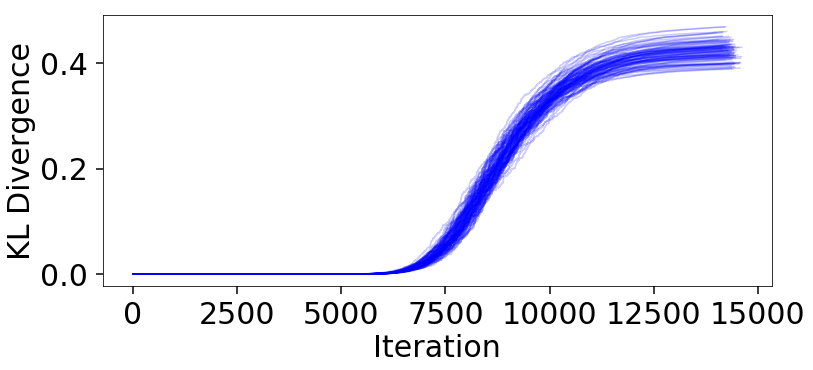

In [25]:
# plot KL divergence
plt.figure(figsize=(12, 5))
for kld in klds:
    plt.plot(kld, color='blue', alpha=0.2)
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

The behavior appears qualitatively similar to our evidence results, since the majority of the KL divergence is coming from summing over the bulk of the posterior mass. The variation in these results are shown below.

Mean:    0.424
Std:     0.018
Std(%):  4.226


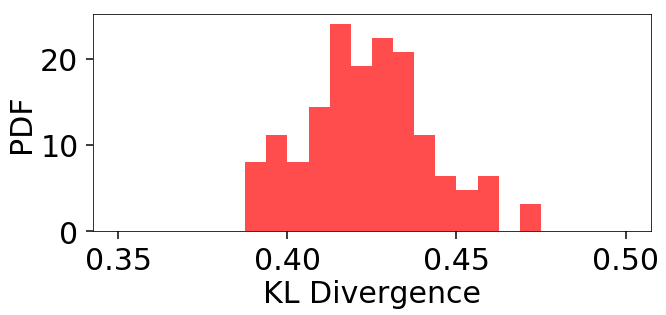

In [26]:
kl_div = [kld[-1] for kld in klds]
kl_div_mean, kl_div_std = np.mean(kl_div), np.std(kl_div)

# plot results
plt.figure(figsize=(10, 4))
plt.hist(kl_div, bins=np.linspace(0.35, 0.5, 25), color='red', alpha=0.7, normed=True)
plt.xlabel('KL Divergence')
plt.ylabel('PDF')

# summarize results
print('Mean:   {:6.3f}'.format(kl_div_mean))
print('Std:    {:6.3f}'.format(kl_div_std))
print('Std(%): {:6.3f}'.format(kl_div_std / kl_div_mean * 100.))

How does our dynamic sampling run *with the exact same number of samples* compare?

In [27]:
klds2 = []
for i in range(Nrepeat):
    kld = dynesty.utils.kld_error(dres)
    klds2.append(kld)
    sys.stderr.write('{0} '.format(i))
kl_div2 = [kld[-1] for kld in klds2]
kl_div2_mean, kl_div2_std = np.mean(kl_div2), np.std(kl_div2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Mean:    0.422
Std:     0.011
Std(%):  2.512


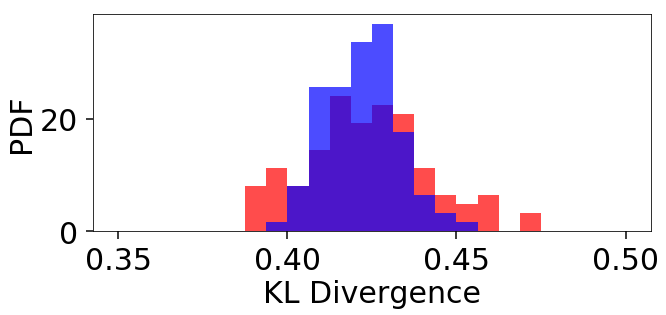

In [28]:
# plot results
plt.figure(figsize=(10, 4))
plt.hist(kl_div, bins=np.linspace(0.35, 0.5, 25), color='red', alpha=0.7, normed=True)
plt.hist(kl_div2, bins=np.linspace(0.35, 0.5, 25), color='blue', alpha=0.7, normed=True)
plt.xlabel('KL Divergence')
plt.ylabel('PDF')

# summarize results
print('Mean:   {:6.3f}'.format(kl_div2_mean))
print('Std:    {:6.3f}'.format(kl_div2_std))
print('Std(%): {:6.3f}'.format(kl_div2_std / kl_div2_mean * 100.))

As expected, while the mean value is almost identical, the fractional standard deviation is significantly lower at around 2.5% rather than 4%.

# Summary

Nested sampling results contain two sources of error: statistical uncertainties associated with the unknown prior volume and sampling uncertainties associated with Monte Carlo noise. Both of these uncertainties, however, can be quantified *using a single (dynamic) nested sampling run*. The statistical uncertainties can be probed directly by simulating the prior volumes, while the sampling uncertainties can be probed using a bootstrap-like resampling of the unique particles (live points) used in a given run. Individual realizations can be computed using functions in the `utils` module, which can be used to check posterior moment stability (via, e.g., `mean_and_cov`) and posterior "noise" (via, e.g., `kld_error`).